In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/CRONOS/Portus/

/content/drive/MyDrive/CRONOS/Portus


In [ ]:
#Code to obtain a landmask from a bathymetry image with neural network
#based on https://towardsdatascience.com/neural-network-for-satellite-data-classification-using-tensorflow-in-python-a13bcf38f3e1

In [ ]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
avgfile=Dataset('HIS_FILE_20210723_5D0-20210727_5D0_fore.nc')  #ROMS file to train/test

In [ ]:
grd = avgfile
x_roms = grd.variables['lon_rho'][:]
y_roms = grd.variables['lat_rho'][:]
msk_roms = grd.variables['mask_rho'][:]
h_roms = grd.variables['h'][:]

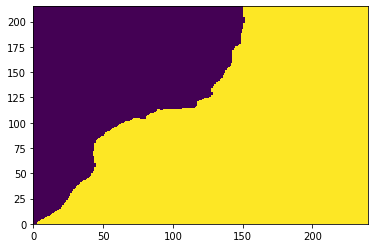

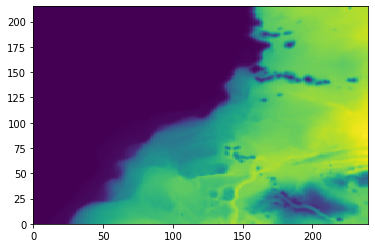

In [ ]:
#create train figures from ROMS; h.png are the features; Msk.png will be used to create the targets (0/1 - 0 land, 1 water)
plt.pcolor(msk_roms)
plt.savefig('msk.png', dpi=300, transparent=False, bbox_inches="tight")
plt.show()
plt.pcolor(h_roms)
plt.savefig('h.png', dpi=300, transparent=False, bbox_inches="tight")
plt.show()

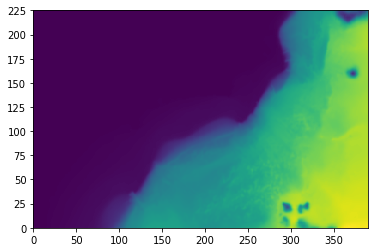

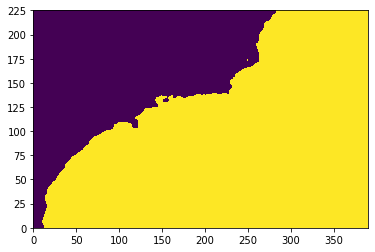

In [ ]:
avgfile=Dataset('HIS_FILE_20210723_5D0-20210727_5D0_fore_NEST_1.nc')  # son grid will be used to apply the model and another testing
grd = avgfile
x_roms2 = grd.variables['lon_rho'][:]
y_roms2 = grd.variables['lat_rho'][:]
msk_roms2 = grd.variables['mask_rho'][:]
h_roms2 = grd.variables['h'][:]
plt.pcolor(h_roms2)
plt.savefig('h_test.png', dpi=300, transparent=False, bbox_inches="tight")
plt.show()
plt.pcolor(msk_roms2)
plt.savefig('msk_test.png', dpi=300, transparent=False, bbox_inches="tight")
plt.show()

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


In [ ]:
# father grid train/testinf
image = load_img('msk.png')
image2 = load_img('h.png')

#son grid testing
image_t = load_img('msk_test.png')
image2_t = load_img('h_test.png')

# convert the image pixels to a numpy array

image = img_to_array(image)
image2 = img_to_array(image2)

image_t = img_to_array(image_t)
image2_t = img_to_array(image2_t)


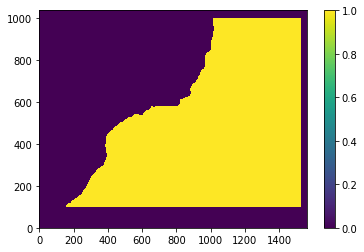

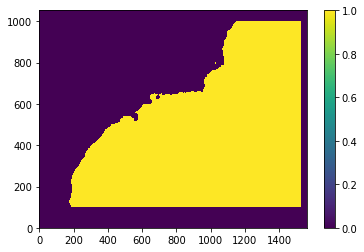

(1053, 1563)

In [ ]:
# create labels array from father and son. 1 water , 0 land
imagez=np.zeros([image.shape[0], image.shape[1]])
imagez[np.where(image[:,:,-1]==37)]=1
imagez_t=np.zeros([image_t.shape[0], image_t.shape[1]])
imagez_t[np.where(image_t[:,:,-1]==37)]=1
plt.pcolor(np.flipud(imagez));plt.colorbar();plt.show()
plt.pcolor(np.flipud(imagez_t));plt.colorbar();plt.show()
imagez_t.shape

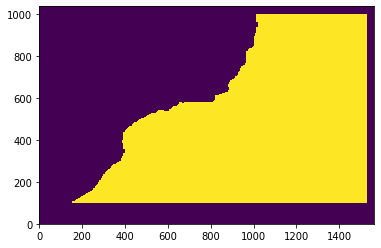

In [ ]:
#testing reshaping
plt.pcolor(np.flipud(np.reshape(imagez.ravel(), [imagez.shape[0],imagez.shape[1]]))); plt.show()

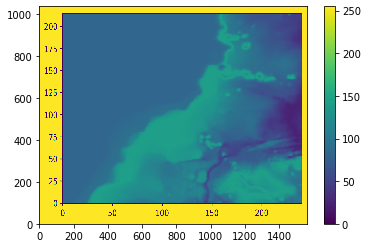

(1037, 1563, 3)
(1620831, 3)


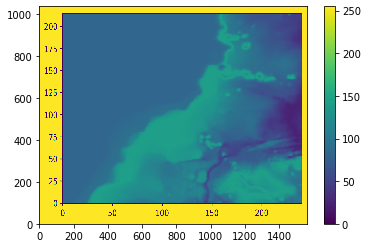

In [ ]:
#testing reshape
plt.pcolor(np.flipud(image2[:,:,-1]));plt.colorbar();plt.show()
print(image2.shape)
print(image2.reshape(-1,3).shape)
tt=np.reshape(image2.reshape(-1, 3), [image2.shape[0],image2.shape[1],3])
plt.pcolor(np.flipud(tt[:,:,-1]));plt.colorbar();plt.show()


In [ ]:
hgt,len, j=image2_t.shape   #indexes for reshaping ahead

#reshaping for Neural network format

image2=image2.reshape(-1, 3)
imagez=imagez.ravel()
image2_t=image2_t.reshape(-1, 3)
imagez_t=imagez_t.ravel()

In [ ]:
print(image2.shape)
print(imagez.shape)
print(image2_t.shape)
print(imagez_t.shape)

(1620831, 3)
(1620831,)
(1645839, 3)
(1645839,)


In [ ]:
#train test with father grid

from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(image2, imagez, test_size=0.2, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(1296664, 3)
(1296664,)
(324167, 3)
(324167,)


In [ ]:
#scaling and reshaping

xTrain = xTrain / 255.0
xTest = xTest / 255.0

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

# Print the shape of reshaped data
print(xTrain.shape, xTest.shape)

(1296664, 1, 3) (324167, 1, 3)


In [ ]:
nBands=xTrain.shape[2]
print(nBands)

3


In [ ]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=2)

Epoch 1/2
40521/40521 [==============================] - 44s 1ms/step - loss: 0.1155 - accuracy: 0.9594
Epoch 2/2
40521/40521 [==============================] - 44s 1ms/step - loss: 0.0539 - accuracy: 0.9834


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[164380     92]
 [  2739 156956]]

P-Score: 0.999, R-Score: 0.983


In [ ]:
# teste com modelo mais mais neuronios
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential


model = Sequential()
model.add(Flatten(input_shape=(1, nBands)))
model.add(Dense(500, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Run the model
model.fit(xTrain, yTrain, epochs=2)
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Epoch 1/2
40521/40521 [==============================] - 96s 2ms/step - loss: 0.0610 - accuracy: 0.9841
Epoch 2/2
40521/40521 [==============================] - 102s 3ms/step - loss: 0.0417 - accuracy: 0.9907
Confusion matrix: for 14 nodes
 [[164472      0]
 [  2739 156956]]

P-Score: 1.000, R-Score: 0.983


In [ ]:
#processing son testing image
image2_t_n = image2_t.reshape((image2_t.shape[0], 1, image2_t.shape[1]))
image2_t_n.shape


(1645839, 1, 3)

In [ ]:
yTestPredicted = model.predict(image2_t_n/255.0)


In [ ]:
print(imagez_t.shape)
print(yTestPredicted.shape)


(1645839,)
(1645839, 2)


In [ ]:
yTestPredicted = yTestPredicted[:,1]
yTestPredicted = (yTestPredicted>0.5).astype(int)

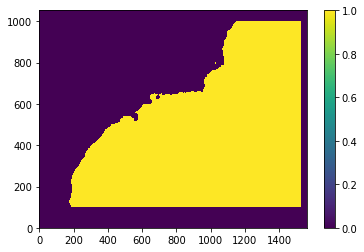

In [ ]:
plt.pcolor(np.flipud(np.reshape(imagez_t, [hgt,len])));plt.colorbar(); plt.show()

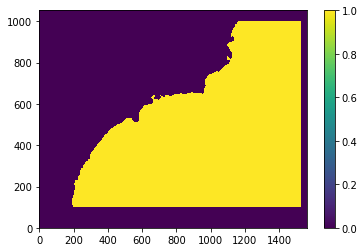

In [ ]:
plt.pcolor(np.flipud(np.reshape(yTestPredicted, [hgt,len])));plt.colorbar(); plt.show()

In [ ]:
cMatrix = confusion_matrix(imagez_t, yTestPredicted)
pScore = precision_score(imagez_t, yTestPredicted)
rScore = recall_score(imagez_t, yTestPredicted)

print("Confusion matrix: for 14 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 14 nodes
 [[821986   1350]
 [ 23636 798867]]

P-Score: 0.998, R-Score: 0.971


In [ ]:
model.save('aaa')

INFO:tensorflow:Assets written to: aaa/assets


In [ ]:
model2 = keras.models.load_model('aaa')


In [ ]:
yTestPredicted2 = model2.predict(image2_t_n/255.0)


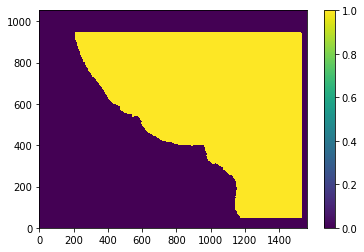

In [ ]:
yTestPredicted2 = yTestPredicted2[:,1]
yTestPredicted2 = (yTestPredicted2>0.5).astype(int)
plt.pcolor(np.reshape(yTestPredicted2, [hgt,len]));plt.colorbar(); plt.show()